In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Shrek6


In [3]:
column_name_mapping = {
    "filename": "Track_Name",
    "length": "Duration",
    "chroma_stft_mean": "Average_Note_Intensity",
    "chroma_stft_var": "Note_Intensity_Variability",
    "rms_mean": "Loudness_Average",
    "rms_var": "Loudness_Variability",
    "spectral_centroid_mean": "Brightness_Average",
    "spectral_centroid_var": "Brightness_Variability",
    "spectral_bandwidth_mean": "Sound_Richness_Average",
    "spectral_bandwidth_var": "Sound_Richness_Variability",
    "rolloff_mean": "Bass_to_Treble_Balance_Average",
    "rolloff_var": "Bass_to_Treble_Balance_Variability",
    "zero_crossing_rate_mean": "Percussiveness_Average",
    "zero_crossing_rate_var": "Percussiveness_Variability",
    "harmony_mean": "Harmonic_Content_Average",
    "harmony_var": "Harmonic_Content_Variability",
    "perceptr_mean": "Sharpness_Average",
    "perceptr_var": "Sharpness_Variability",
    "tempo": "Tempo",
    # MFCCs grouped
    **{f"mfcc{i}_mean": f"MFCC{i}_Average" for i in range(1, 21)},
    **{f"mfcc{i}_var": f"MFCC{i}_Variability" for i in range(1, 21)},
    "label": "Genre"
}


In [4]:
path = "D:/Coding/VS/Projects/Audio Genres/features_30_sec.csv/features_30_sec.csv"
data = pd.read_csv(path)

data_labeled = data.rename(columns=column_name_mapping)
data_labeled = data_labeled.drop(columns="Duration")
data_labeled.isnull().sum() 

scaler = StandardScaler()
le = LabelEncoder()

data_labeled["Genre"] = le.fit_transform(data_labeled["Genre"])


X = data_labeled.iloc[:, 1:-1]
y = data_labeled["Genre"]





In [ ]:
for col in data_labeled.columns[1:-1]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data_labeled["Genre"], y=data_labeled[col])
    plt.title(f"Boxplot of {col} by Genre")
    plt.xlabel("Genre")
    plt.ylabel(col)
    plt.show()


In [ ]:
correlation_matrix = X.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")


In [7]:

# Find highly correlated features
high_corr_pairs = np.where(((correlation_matrix > 0.9) | (correlation_matrix < -0.9)) & (correlation_matrix != 1.0))
correlated_features = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_pairs)]

correlated_features_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2'])
correlated_features_df

,Feature 1,Feature 2
0,Brightness_Average,Sound_Richness_Average
1,Brightness_Average,Bass_to_Treble_Balance_Average
2,Brightness_Average,MFCC2_Average
3,Sound_Richness_Average,Brightness_Average
4,Sound_Richness_Average,Bass_to_Treble_Balance_Average
5,Bass_to_Treble_Balance_Average,Brightness_Average
6,Bass_to_Treble_Balance_Average,Sound_Richness_Average
7,Bass_to_Treble_Balance_Average,MFCC2_Average
8,MFCC2_Average,Brightness_Average
9,MFCC2_Average,Bass_to_Treble_Balance_Average


In [8]:
X_uncor = X.drop(columns=['MFCC2_Average','Brightness_Average','Sound_Richness_Average' ])
X_uncor_scaled = scaler.fit_transform(X_uncor)

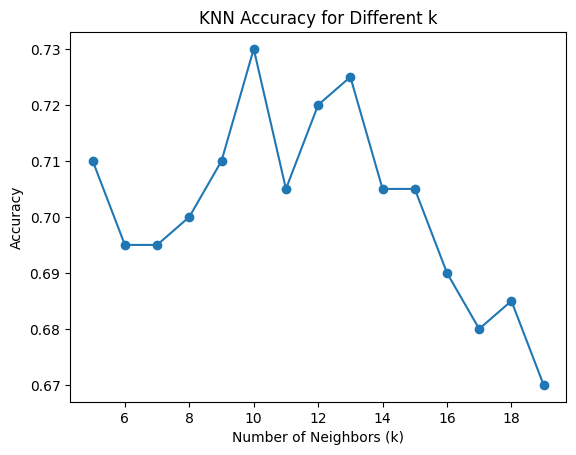

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X_uncor_scaled, y, test_size=0.2, random_state=69, stratify=y)

k = range(5, 20)
accuracies = []

for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(k, accuracies, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy for Different k")
plt.show()

## the results are far from being good, let's try to add more hyperparameters

In [10]:
#Let's try to use GridSearchCV to find the best hyperparameters

param_grid = {
    'n_neighbors': list(range(1, 20)), 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}


knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))

# Did not help much

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Test Accuracy: 0.725


Explained Variance by Component 1: 23.95%
Explained Variance by Component 2: 16.93%
Total Explained Variance by First 2 Components: 40.88%


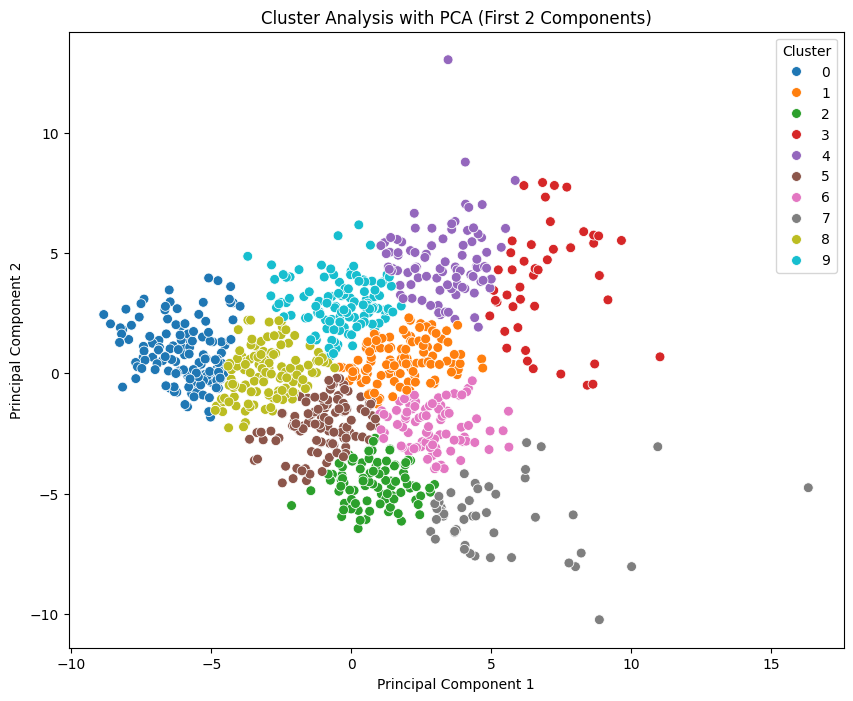

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensions to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component 1: {explained_variance[0]*100:.2f}%")
print(f"Explained Variance by Component 2: {explained_variance[1]*100:.2f}%")
print(f"Total Explained Variance by First 2 Components: {explained_variance.sum()*100:.2f}%")

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualize Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10', s=50)
plt.title("Cluster Analysis with PCA (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc='best')
plt.show()

# the explained variance of the first 2 components is not enough to explain the data + the cli=u

In [15]:
genre_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Encoded Labels:", genre_mapping)

Encoded Labels: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
